### Introduction 
In this exercise you will work with stock market data. We use the data available at [Yahoo Finance](https://finance.yahoo.com/quote/DAX/history?period1=1478390400&period2=1604534400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)
You will build sequential models to predict the variations for Global X DAX Germany ETF (DAX). The goal is to predict whether the stock value is higher or lower than its actual value of previous day.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading and Preprocessing Data

In [ ]:
# Loading training data
training_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LSTM/dax_train_2019.csv.txt", sep=",")
print(f"Training data column info:\n {training_data.dtypes}")
print(f"Training data shape is {training_data.shape}")

Training data column info:
 date          object
open         float64
high         float64
low          float64
close        float64
adj_close    float64
volume         int64
dtype: object
Training data shape is (644, 7)


In [ ]:
# Loading testing data
testing_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LSTM/dax_test_2019.csv.txt", sep=",")
print(f"Testing data column info:\n {testing_data.dtypes}")
print(f"Testing data shape is {testing_data.shape}")

Testing data column info:
 date          object
open         float64
high         float64
Low          float64
close        float64
adj_close    float64
volume         int64
dtype: object
Testing data shape is (148, 7)


####  Are there any NaN values in training and testing data sets?

In [ ]:

training_count_nan = training_data.shape[0] - training_data.count()
testing_count_nan = testing_data.shape[0] - testing_data.count()
print(f"Number of NaNs in training data columns:\n{training_count_nan}")
print(f"Number of NaNs in testing data columns:\n{testing_count_nan}")

Number of NaNs in training data columns:
date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64
Number of NaNs in testing data columns:
date         0
open         0
high         0
Low          0
close        0
adj_close    0
volume       0
dtype: int64


#### Preprocessing the data, extracting the features, and normalising the features using `preprocessing.MinMaxScaler` function from sklearn

We have provided you with the relevant function here. But we expect you to explore the data generated. 

What are the shapes?

Do a test whether features and labels correspond, i.e. whether the label for each sequence is the value following that sequence? 

Optional: Extend the function to include more features - and change it 
to choose a different column as target, i.e. adj_close


In [ ]:
# Limiting the training and testing data to "open" column 
training_data_processed = training_data.iloc[:, 1:2].values
testing_data_processed = testing_data.iloc[:, 1:2].values

In [ ]:
def create_features_labels(training_data, testing_data, scaler=MinMaxScaler(feature_range = (0, 1)), sequence_length=60):
    """
    Create feature and labels from training data
    :param training_data
    :param testing_data
    :param sequence_length
    :param scaler
    :return: Features and labels sets, and labels bins
    """
    features_set = []
    labels = []
    labels_bin = []
    test_features = []
    # Limiting the training and testing data to relevant column (here "open" column)
    training_data_processed = training_data.iloc[:, 1:2].values
    # Normalization: Transform features by scaling each feature in training to be in a range of (0, 1)
    training_data_processed = scaler.fit_transform(training_data_processed)
    # Preparing training data features and labels
    for i in range(sequence_length, len(training_data)):
        features_set.append(training_data_processed[i-sequence_length:i, 0])
        labels.append(training_data_processed[i, 0])
        # Fill binary labels
        if training_data_processed[i,0] > training_data_processed[i-1,0]:
            labels_bin.append(1)
        else:
            labels_bin.append(0)
    # Preparing the testing data features
    total = pd.concat((training_data['open'], testing_data['open']), axis=0)
    test_inputs = total[len(total) - len(testing_data) - sequence_length:].values
    test_inputs = test_inputs.reshape(-1,1)
    test_inputs = scaler.transform(test_inputs)

    for i in range(sequence_length, len(test_inputs)):
        test_features.append(test_inputs[i-sequence_length:i, 0])
    
    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    features_set, labels, labels_bin = np.array(features_set), np.array(labels), np.array(labels_bin)
    return np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1)), labels, labels_bin, test_features, scaler

In [ ]:
features_set, labels, labels_bin, test_features, scaler = create_features_labels(training_data, testing_data, MinMaxScaler(feature_range = (0, 1)), 60)

### Model
In this section we ask you to build and train a LSTM neural network and use it predict the stock price variations on your testing data.

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
def lstm_model(input_shape):
    # TODO: Implement your model here. 
    # (Hint: Make use of `Sequential` function from tensorflow.keras to group a linear stack of layers into the model. In addition, 
    # you can apply droupouts to your input using `Dropout` from tensorflow.keras.layers)
    model = Sequential()

    model.add(LSTM(units = 50, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))
      
    return model

In [ ]:
## Callbacks ##

rlop = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, verbose=1, min_lr=0.0001)

mcp = ModelCheckpoint('best_model', monitor='val_loss', save_best_only=True, verbose=1)

In [ ]:
## Compile and train model ##

input_shape= (features_set.shape[1],1)

model = lstm_model(input_shape)

from tensorflow.keras.optimizers import Adam
optim = Adam(lr=0.001)

model.compile(optimizer = 'adam', loss='mean_squared_error', metrics = ['mean_absolute_error'])

model.fit(features_set, labels,  validation_split = 0.2,  epochs = 100, batch_size=32, callbacks=[mcp, rlop], verbose=1)

Compile your model, train it and evaluate it. 

What is your mse - and what is your accuracy (note that you have two different types of labels readily available to you). 



In [ ]:
# load best_model
best_model = load_model('best_model')


In [ ]:
# lets predict 
predictions = best_model.predict(test_features)

In [ ]:
# inverse transfrom our predictions
predictions = scaler.inverse_transform(predictions)

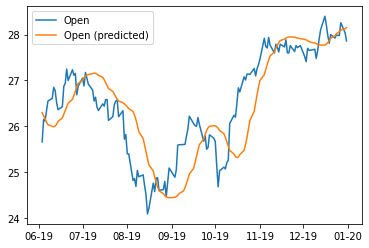

In [ ]:
# Lets plot the results
df = pd.DataFrame()
df = testing_data
df["predictions"] = predictions

# https://matplotlib.org/gallery/text_labels_and_annotations/date.html

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%m-%y')

# format the ticks
ax = plt.gca()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)


dates = np.array(df["date"]).astype(np.datetime64)

plt.plot(dates[:], df["open"][:], label="Open")
plt.plot(dates[:], df["predictions"][:], label="Open (predicted)")

plt.legend()

plt.show()

Optional: Try your model with more features, try with different sequence lengths (this is a hyperparameter) - and try with the "real" Dax Performance Index data also provided (which reaches back longer). If you do so, you will have to split the data into training and test sets first). 

# Use different sequence lenghts: 

In [ ]:
def try_different_sequence_lenghts(sequence_length): 
 # Data Preparation
 features_set, labels, labels_bin, test_features, scaler = create_features_labels(training_data, testing_data, MinMaxScaler(feature_range = (0, 1)), sequence_length)

 # Build model
 input_shape= (features_set.shape[1],1)
 model = lstm_model(input_shape)
 from tensorflow.keras.optimizers import Adam
 optim = Adam(lr=0.001)

 # compile & train model
 model.compile(optimizer = 'adam', loss='mean_squared_error', metrics = ['mean_absolute_error'])
 model.fit(features_set, labels,  validation_split = 0.2,  epochs = 100, batch_size=32, verbose=0)

 # make predictions: 
 predictions = model.predict(test_features)
 predictions = scaler.inverse_transform(predictions)

 # Lets plot the results
 df = pd.DataFrame()
 df = testing_data
 df["predictions"] = predictions

 # https://matplotlib.org/gallery/text_labels_and_annotations/date.html

 %matplotlib inline

 import matplotlib.pyplot as plt
 import matplotlib.dates as mdates
 import matplotlib.cbook as cbook

 years = mdates.YearLocator()   # every year
 months = mdates.MonthLocator()  # every month
 yearsFmt = mdates.DateFormatter('%m-%y')

 # format the ticks
 ax = plt.gca()
 ax.xaxis.set_major_locator(months)
 ax.xaxis.set_major_formatter(yearsFmt)
 ax.xaxis.set_minor_locator(months)

 dates = np.array(df["date"]).astype(np.datetime64)

 plt.plot(dates[:], df["open"][:], label="Open")
 plt.plot(dates[:], df["predictions"][:], label="Open (predicted)")

 plt.legend()

 plt.show()

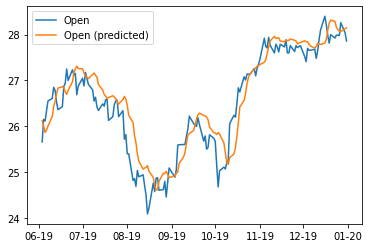

In [ ]:
try_different_sequence_lenghts(sequence_length = 5)

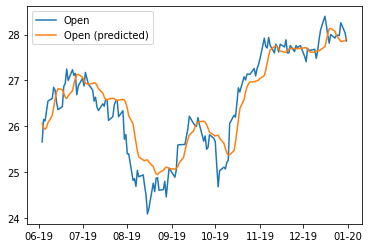

In [ ]:
try_different_sequence_lenghts(sequence_length = 20)

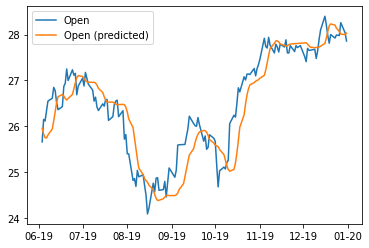

In [ ]:
try_different_sequence_lenghts(sequence_length = 80)

# Try to predict TESLA stock 

In [ ]:
# Loading training data
tesla_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LSTM/TSLA.csv", sep=",")
tesla_data = tesla_data.rename(columns={'Open': 'open', 'Date':'date'})

In [ ]:
tesla_data['date'] = pd.to_datetime(tesla_data['date'])

split_date = pd.datetime(2020,7,31)

tesla_training = tesla_data.loc[tesla_data['date'] <= split_date]
tesla_test = tesla_data.loc[tesla_data['date'] > split_date]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def try_different_stocks(training_data, testing_data,sequence_length): 
 # Data Preparation
 features_set, labels, labels_bin, test_features, scaler = create_features_labels(training_data, testing_data, MinMaxScaler(feature_range = (0, 1)), sequence_length)

 # Build model
 input_shape= (features_set.shape[1],1)
 model = lstm_model(input_shape)
 from tensorflow.keras.optimizers import Adam
 optim = Adam(lr=0.001)

 # compile & train model
 model.compile(optimizer = 'adam', loss='mean_squared_error', metrics = ['mean_absolute_error'])
 model.fit(features_set, labels,  validation_split = 0.2,  epochs = 100, batch_size=32, verbose=0)

 # make predictions: 
 predictions = model.predict(test_features)
 predictions = scaler.inverse_transform(predictions)

 # Lets plot the results
 df = pd.DataFrame()
 df = testing_data
 df["predictions"] = predictions

 # https://matplotlib.org/gallery/text_labels_and_annotations/date.html

 %matplotlib inline

 import matplotlib.pyplot as plt
 import matplotlib.dates as mdates
 import matplotlib.cbook as cbook

 years = mdates.YearLocator()   # every year
 months = mdates.MonthLocator()  # every month
 yearsFmt = mdates.DateFormatter('%m-%y')

 # format the ticks
 ax = plt.gca()
 ax.xaxis.set_major_locator(months)
 ax.xaxis.set_major_formatter(yearsFmt)
 ax.xaxis.set_minor_locator(months)

 dates = np.array(df["date"]).astype(np.datetime64)

 plt.plot(dates[:], df["open"][:], label="Open")
 plt.plot(dates[:], df["predictions"][:], label="Open (predicted)")

 plt.legend()

 plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


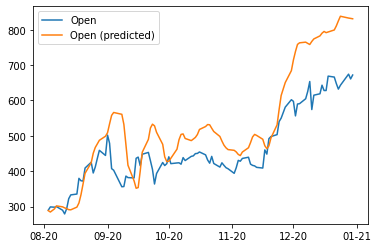

In [ ]:
training_data = tesla_training
testing_data = tesla_test
sequence_length = 10
try_different_stocks(training_data, testing_data, sequence_length)

# Use more features: 

In [ ]:
# choose features
training_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LSTM/dax_train_2019.csv.txt", sep=",")
testing_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LSTM/dax_test_2019.csv.txt", sep=",")

testing_data = testing_data.rename(columns={'Low': 'low'})
features = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

In [ ]:
def model_with_multiple_features(features, sequence_length):
 # Skalierung 
 from sklearn.preprocessing import MinMaxScaler
 # traindata
 minmax = MinMaxScaler(feature_range = (0, 1))
 train_scaled = minmax.fit_transform(training_data[features])
 train_scaled = pd.DataFrame(train_scaled, columns = training_data[features].columns) 

 # needed later: 
 minmax_single = MinMaxScaler(feature_range = (0, 1))
 minmax_single.fit_transform(training_data[['open']])
 # testdata 
 test_scaled = minmax.transform(testing_data[features])                   
 test_scaled = pd.DataFrame(test_scaled, columns = testing_data[features].columns) 

 # Create Total Df for Test Set
 total = pd.concat((train_scaled, test_scaled), axis=0)
 test_inputs = total[len(total) - len(test_scaled) - sequence_length:].values

 #Training Data prepare Input Sequence
 train_scaled = train_scaled.values
 X_train = []
 y_train = []
 for i in range(sequence_length, train_scaled.shape[0]):
  X_train.append(train_scaled[i-sequence_length:i])
  y_train.append(train_scaled[i,0])

 X_train, y_train = np.array(X_train), np.array(y_train)
 X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))

 # Test Data prepare Input Sequence

 X_test = []
 y_test = []

 for i in range(sequence_length, test_inputs.shape[0]):
  X_test.append(test_inputs[i-sequence_length:i])
  y_test.append(test_inputs[i,0])

 X_test, y_test = np.array(X_test), np.array(y_test)
 X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],len(features)))


 # Build model
 input_shape= (X_train.shape[1],len(features))
 model = lstm_model(input_shape)
 from tensorflow.keras.optimizers import Adam
 optim = Adam(lr=0.001)

 # compile & train model
 model.compile(optimizer = 'adam', loss='mean_squared_error', metrics = ['mean_absolute_percentage_error'])
 model.fit(X_train, y_train,  validation_split = 0.2,  epochs = 100, batch_size=32, verbose=0)



 # make predictions
 predictions = model.predict(X_test)
 predictions = minmax_single.inverse_transform(predictions)


 # Lets plot the results
 df = pd.DataFrame()
 df = testing_data
 df["predictions"] = predictions

 %matplotlib inline

 years = mdates.YearLocator()   # every year
 months = mdates.MonthLocator()  # every month
 yearsFmt = mdates.DateFormatter('%m-%y')

 # format the ticks
 ax = plt.gca()
 ax.xaxis.set_major_locator(months)
 ax.xaxis.set_major_formatter(yearsFmt)
 ax.xaxis.set_minor_locator(months)
 
 dates = np.array(df["date"]).astype(np.datetime64)

 plt.plot(dates[:], df["open"][:], label="Open")
 plt.plot(dates[:], df["predictions"][:], label="Open (predicted)")

 plt.legend()

 plt.show()

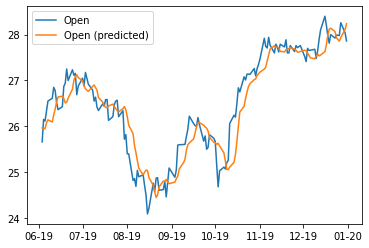

In [ ]:
features = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
sequence_length = 5
model_with_multiple_features(features, sequence_length)

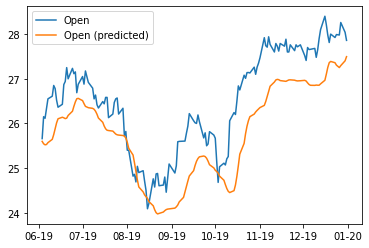

In [ ]:
features = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
sequence_length = 40
model_with_multiple_features(features, sequence_length)

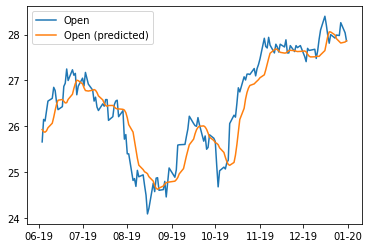

In [ ]:
features = ['open', 'high', 'low', 'close']
sequence_length = 40
model_with_multiple_features(features, sequence_length)

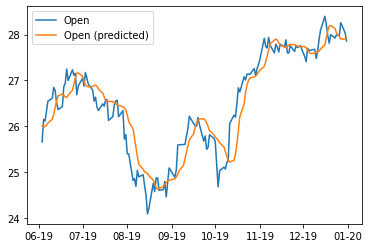

In [ ]:
features = ['open', 'close']
sequence_length = 40
model_with_multiple_features(features, sequence_length)

# Final verdict

I observe that my model replicates the stock performance rather than predicting it. Therefore, unfortunately, I do not get rich so easily. :D 

# Playground, Manipulate Stock

In [ ]:
# Loading training data
tesla_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LSTM/TSLA.csv", sep=",")
tesla_data = tesla_data.rename(columns={'Open': 'open', 'Date':'date'})

In [ ]:
tesla_data 

,date,open,High,Low,Close,Adj Close,Volume
0,2020-01-02,84.900002,86.139999,84.342003,86.052002,86.052002,47660500
1,2020-01-03,88.099998,90.800003,87.384003,88.601997,88.601997,88892500
2,2020-01-06,88.094002,90.311996,88.000000,90.307999,90.307999,50665000
3,2020-01-07,92.279999,94.325996,90.671997,93.811996,93.811996,89410500
4,2020-01-08,94.739998,99.697998,93.646004,98.428001,98.428001,155721500
...,...,...,...,...,...,...,...
247,2020-12-23,632.200012,651.500000,622.570007,645.979980,645.979980,33173000
248,2020-12-24,642.989990,666.090027,641.000000,661.770020,661.770020,22865600
249,2020-12-28,674.510010,681.400024,660.799988,663.690002,663.690002,32278600
250,2020-12-29,661.000000,669.900024,655.000000,665.989990,665.989990,22910800


In [ ]:
for i in range(len(tesla_data)):
  
 if (i % 2) == 0:
  tesla_data['open'].iloc[i] = 100
 else:
  tesla_data['open'].iloc[i] = 110 

tesla_data

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,date,open,High,Low,Close,Adj Close,Volume
0,2020-01-02,100.0,86.139999,84.342003,86.052002,86.052002,47660500
1,2020-01-03,110.0,90.800003,87.384003,88.601997,88.601997,88892500
2,2020-01-06,100.0,90.311996,88.000000,90.307999,90.307999,50665000
3,2020-01-07,110.0,94.325996,90.671997,93.811996,93.811996,89410500
4,2020-01-08,100.0,99.697998,93.646004,98.428001,98.428001,155721500
...,...,...,...,...,...,...,...
247,2020-12-23,110.0,651.500000,622.570007,645.979980,645.979980,33173000
248,2020-12-24,100.0,666.090027,641.000000,661.770020,661.770020,22865600
249,2020-12-28,110.0,681.400024,660.799988,663.690002,663.690002,32278600
250,2020-12-29,100.0,669.900024,655.000000,665.989990,665.989990,22910800


In [ ]:
tesla_data['date'] = pd.to_datetime(tesla_data['date'])

split_date = pd.datetime(2020,7,31)

tesla_training = tesla_data.loc[tesla_data['date'] <= split_date]
tesla_test = tesla_data.loc[tesla_data['date'] > split_date]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def try_different_stocks(training_data, testing_data,sequence_length): 
 # Data Preparation
 features_set, labels, labels_bin, test_features, scaler = create_features_labels(training_data, testing_data, MinMaxScaler(feature_range = (0, 1)), sequence_length)

 # Build model
 input_shape= (features_set.shape[1],1)
 model = lstm_model(input_shape)
 from tensorflow.keras.optimizers import Adam
 optim = Adam(lr=0.001)

 # compile & train model
 model.compile(optimizer = 'adam', loss='mean_squared_error', metrics = ['mean_absolute_error'])
 model.fit(features_set, labels,  validation_split = 0.2,  epochs = 100, batch_size=32, verbose=0)

 # make predictions: 
 predictions = model.predict(test_features)
 predictions = scaler.inverse_transform(predictions)

 # Lets plot the results
 df = pd.DataFrame()
 df = testing_data
 df["predictions"] = predictions

 # https://matplotlib.org/gallery/text_labels_and_annotations/date.html

 %matplotlib inline

 import matplotlib.pyplot as plt
 import matplotlib.dates as mdates
 import matplotlib.cbook as cbook

 years = mdates.YearLocator()   # every year
 months = mdates.MonthLocator()  # every month
 yearsFmt = mdates.DateFormatter('%m-%y')

 # format the ticks
 ax = plt.gca()
 ax.xaxis.set_major_locator(months)
 ax.xaxis.set_major_formatter(yearsFmt)
 ax.xaxis.set_minor_locator(months)

 dates = np.array(df["date"]).astype(np.datetime64)

 plt.plot(dates[:], df["open"][:], label="Open")
 plt.plot(dates[:], df["predictions"][:], label="Open (predicted)")

 plt.legend()

 plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


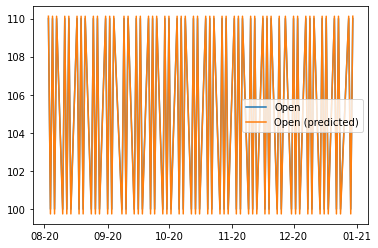

In [ ]:
training_data = tesla_training
testing_data = tesla_test
sequence_length = 20
try_different_stocks(training_data, testing_data, sequence_length)

With such an uniform stock performance, even my model is able to predict the price correctly. 